<a href="https://colab.research.google.com/github/LuciusMelillo09/DataScience/blob/main/Unit4/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



In [2]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [3]:
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [4]:
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [5]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [6]:
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [7]:
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [27]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu=3, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  nu=3, # degrees of freedom for StudentT
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu=3, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu=3,
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical - GEMINI
    idata_cs_h = pm.sample(progressbar=False)
    pm.sample_posterior_predictive(idata_cs_h, extend_inferencedata=True, progressbar=False)

In [26]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample(progressbar=False)
    pm.sample_posterior_predictive(idata_cs_nh, extend_inferencedata=True, progressbar=False) # Added this line

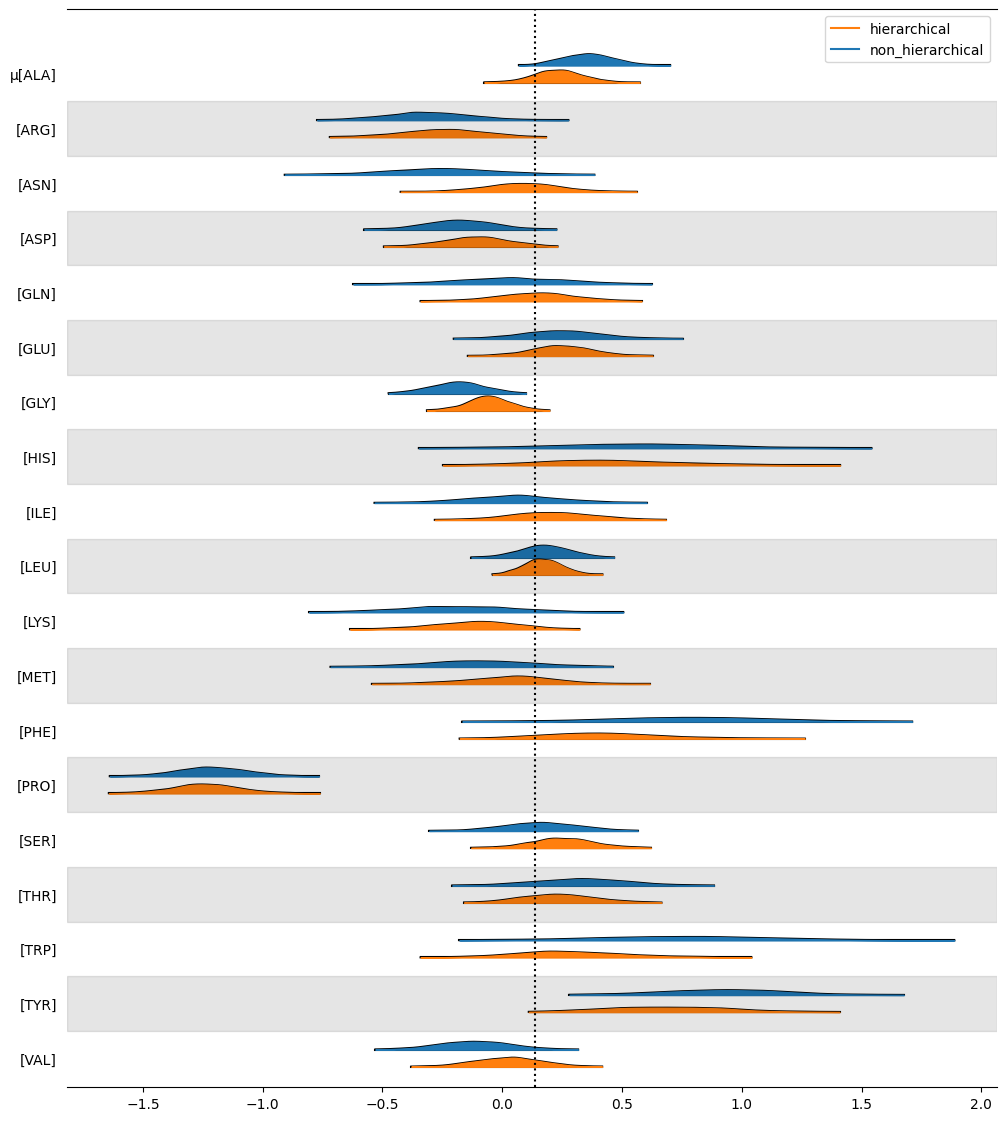

In [10]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [11]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    pm.sample_posterior_predictive(idata_cs_nh, extend_inferencedata=True)

In [12]:
with pm.Model(coords=aa_coords) as cs_h_model:
    pm.sample_posterior_predictive(idata_cs_h, extend_inferencedata=True)

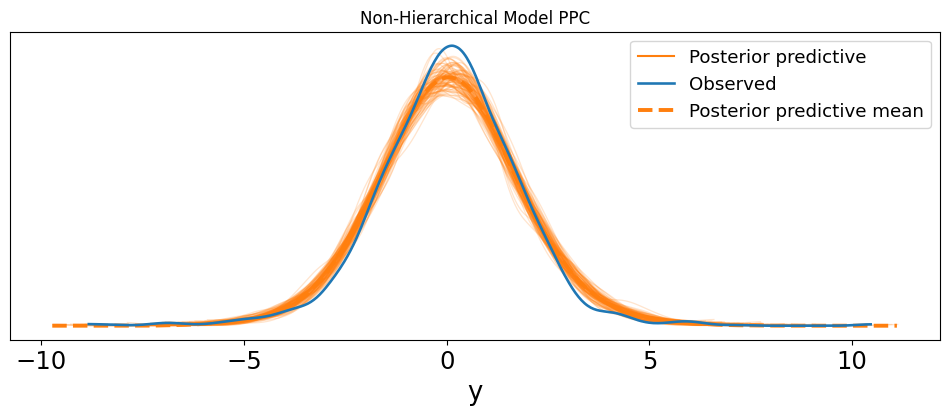

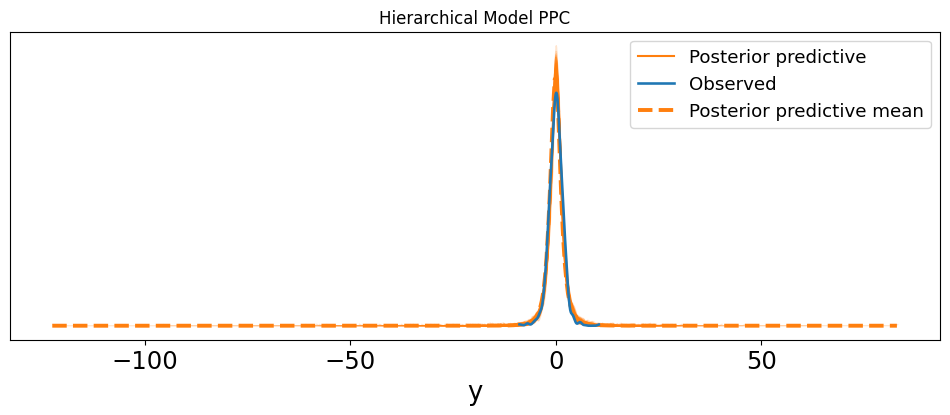

In [13]:
# GEMINI
az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.title('Non-Hierarchical Model PPC')
plt.show()

az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.title('Hierarchical Model PPC')
plt.show()

Hierarchical model looks closer.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [14]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [15]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [16]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [17]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95,progressbar=False)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

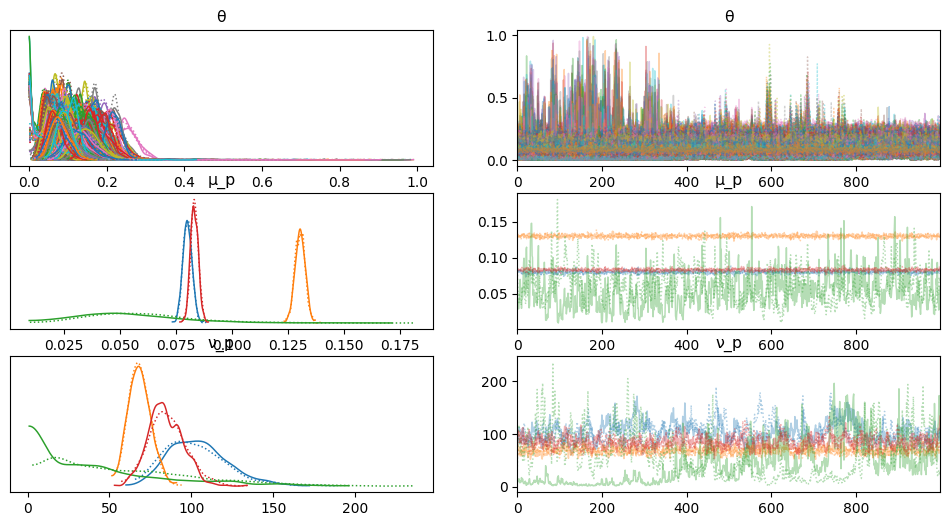

In [18]:
az.plot_trace(idata_sccr)

In [19]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.005 1.001 0.9995 ... 0.9997 1.001 1.009
    μ_p      (pos) float64 32B 1.001 0.9997 1.058 1.002
    ν_p      (pos) float64 32B 1.005 0.9995 1.328 1.011

No hyperprior graphs

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

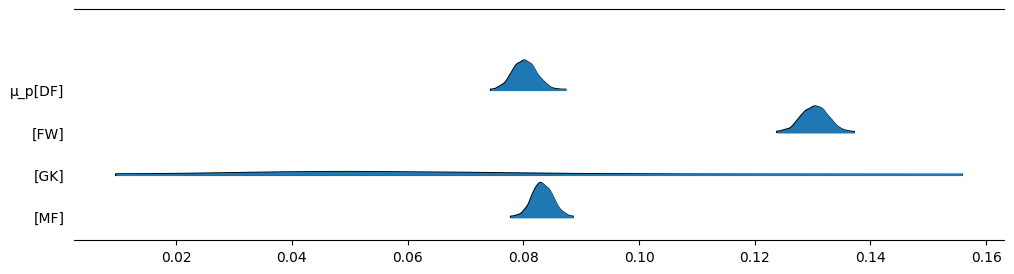

In [20]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [21]:
sccr2_data=sccr_data.query('position != "GK"')
sccr2_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [22]:
pos_idx = sccr2_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr2_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr2_coords = {"pos": pos_codes}

In [23]:
with pm.Model(coords = sccr2_coords) as sccr2_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr2_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr2_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr2 = pm.sample(target_accept = 0.95,progressbar=False)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

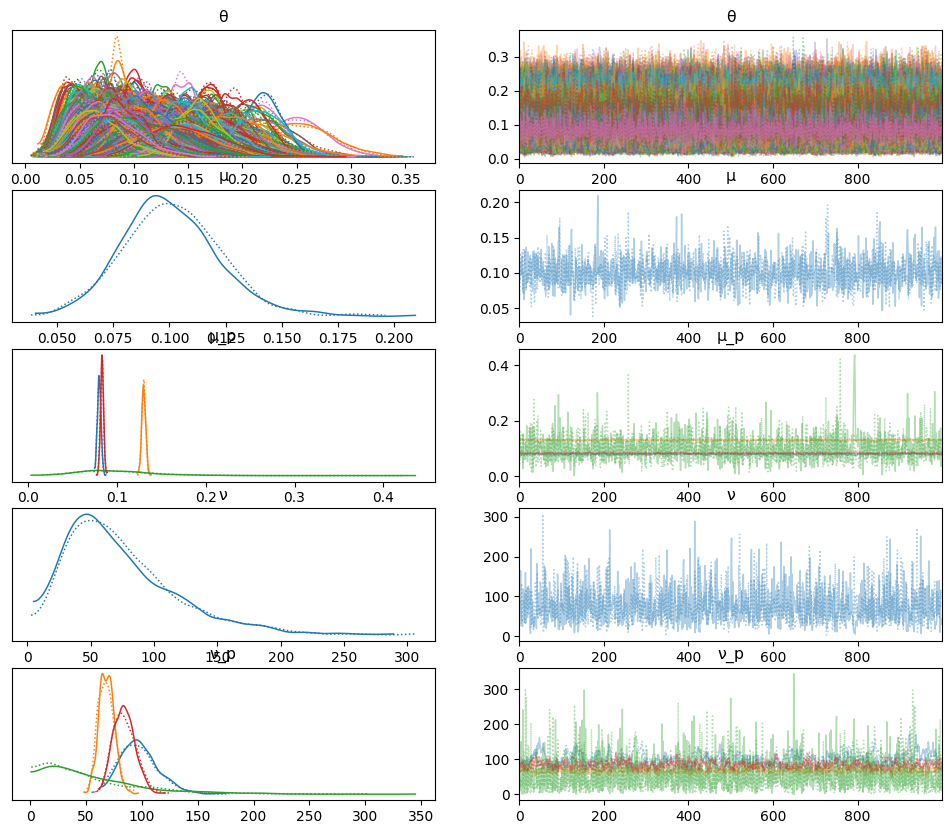

In [24]:
az.plot_trace(idata_sccr2)

In [25]:
az.rhat(idata_sccr2)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9996 1.001 1.003 1.0 ... 1.005 1.001 1.002
    μ        float64 8B 1.002
    μ_p      (pos) float64 32B 1.001 1.0 1.0 1.004
    ν        float64 8B 1.0
    ν_p      (pos) float64 32B 1.017 1.001 1.001 1.004

The Model without the GK ran a little faster, I assume because there was less data.
The top left graph is different than it was for the hierarchical model with GK, and the blue line graphs look like they're more accurately following the dotted line than in the model with GKs.